In [7]:
from meta_kg.utils.py_io import *

# dynamic = read_json("./output/20221124-010221/dev_out-epoch=0_step=11250.json")
dynamic = read_json("./output/20221129-195134/dev_out-epoch=0_step=11250.json")

inner_loss_token_dynamic = []
topk_tokens_dynamic = []
inner_loss_dynamic = []
for log in dynamic:
    inner_loss = log["inner_loss"]
    topk_tokens = log["topk_tokens"]
    inner_loss_token = log["inner_loss_token"]
    inner_loss_dynamic.append(inner_loss)
    topk_tokens_dynamic.append(topk_tokens)
    inner_loss_token_dynamic.append(inner_loss_token)

inner_loss_token_dynamic[0]

[{'4: person': [2.705562114715576, -19.43141222000122],
  '5: M': [3.771568775177002, -0.7037768363952637],
  '6: is': [0.42541980743408203, -4.574638843536377],
  '7: a': [0.7859891057014465, -0.11788052320480347],
  '8: son': [23.650915145874023, 5.497804641723633],
  '9: to': [2.3282690048217773, -7.89206600189209],
  '10: person': [2.354016065597534, -0.806288480758667],
  '11: Q': [5.408966064453125, -2.549128532409668]},
 {'4: person': [4.476999282836914, -13.603630065917969],
  '5: D': [3.600383758544922, -1.2858314514160156],
  '6: is': [0.4053044021129608, -5.041131526231766],
  '7: a': [0.6833508610725403, -0.04421418905258179],
  '8: grandfather': [3.0027360916137695, -20.903111457824707],
  '9: of': [0.4802926182746887, -0.06720203161239624],
  '10: person': [0.7270922660827637, -12.919941425323486],
  '11: M': [3.6115167140960693, -6.064818620681763]}]

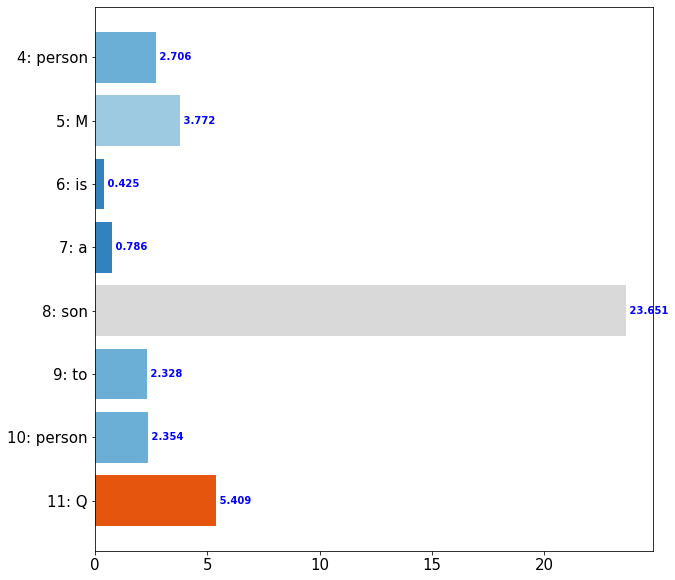

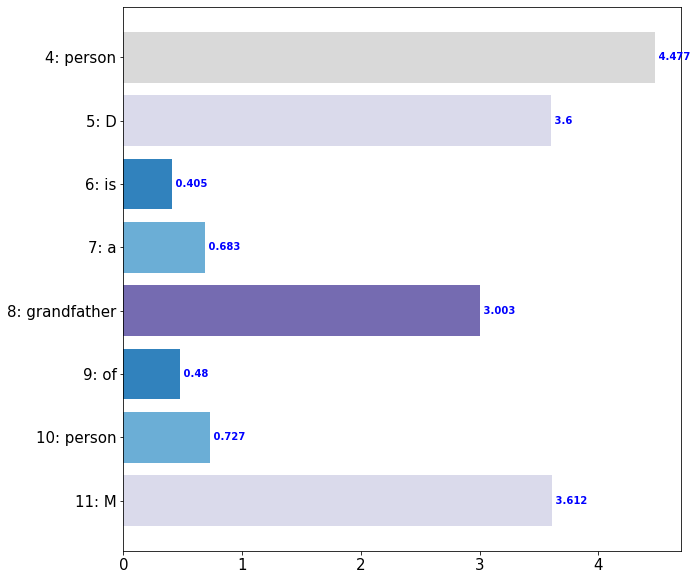

In [5]:
import numpy as np
import matplotlib.pyplot as plt

index = 0


def plot_loss_token(inner_loss_token, index):
    plasma = plt.get_cmap('tab20c')
    def rescale(y): return (y - np.min(y)) / (np.max(y) - np.min(y))

    for token_loss in inner_loss_token:
        tokens = [tok for tok in list(token_loss.keys())]
        tokens.reverse()
        losses = [round(loss[0], 3) for loss in list(token_loss.values())]
        losses.reverse()

        plt.figure(figsize=(10, 10))
        plt.barh(tokens, losses, color=plasma(rescale(losses)))
        plt.xticks(rotation=0, fontsize=15)
        plt.yticks(rotation=0, fontsize=15)
        for i, v in enumerate(losses):
            plt.text(v, i, " "+str(v), color='blue',
                     va='center', fontweight='bold')

        # plt.savefig(f'./output/token_loss_{index}.png', bbox_inches='tight', dpi=300)
        index += 1
        plt.show()


plot_loss_token(inner_loss_token_dynamic[0], index)


['ial', 'person', 'ian', 'iph', 'ier', 'ily', 'vern', '_____', 'ips', 'ery']
[1.042, 1.137, 1.321, 1.527, 1.633, 1.637, 1.907, 2.931, 8.447, 42.751]


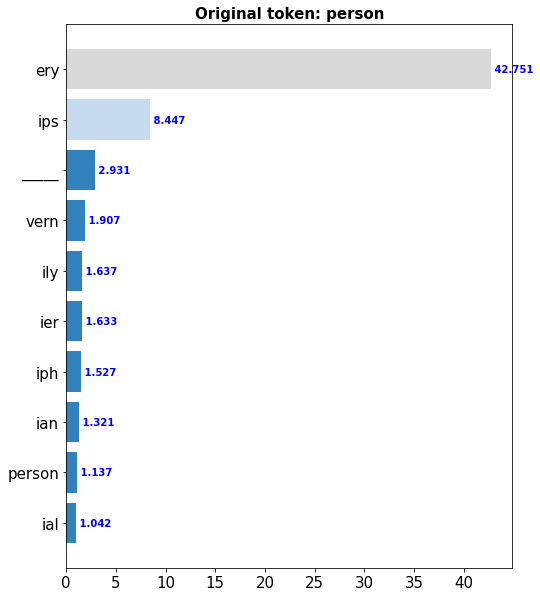

['C', 'E', 'L', 'J', 'W', 'T', 'R', '_', 'B', 'H']
[3.024, 4.272, 4.59, 5.459, 5.616, 5.846, 6.579, 7.508, 10.522, 11.319]


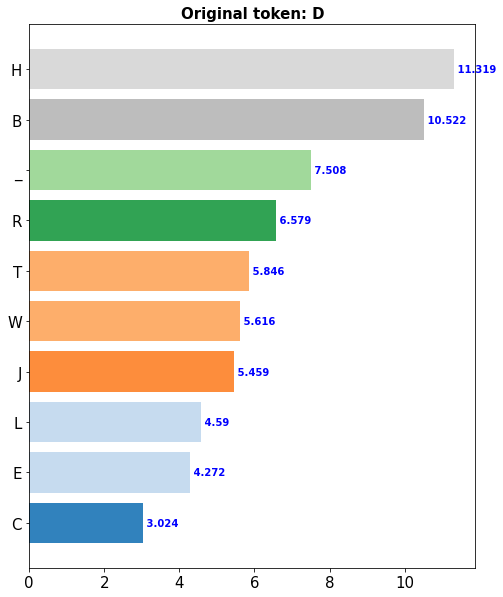

['uh', 'ing', 'in', 'aw', 'in', 'was', '.', 'al', 'has', 'is']
[0.408, 0.443, 0.467, 0.514, 0.672, 1.035, 1.241, 1.923, 4.006, 66.677]


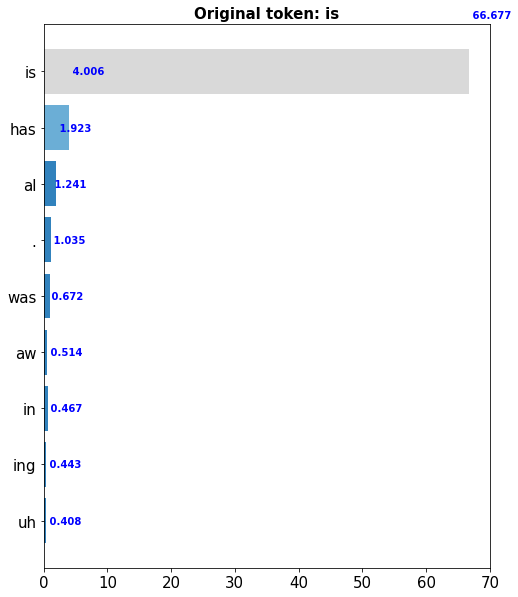

['manager', 'his', '"', 'someone', 'part', 'one', 'an', 'person', 'the', 'a']
[0.18, 0.205, 0.231, 0.583, 0.716, 0.867, 8.608, 9.628, 23.05, 50.492]


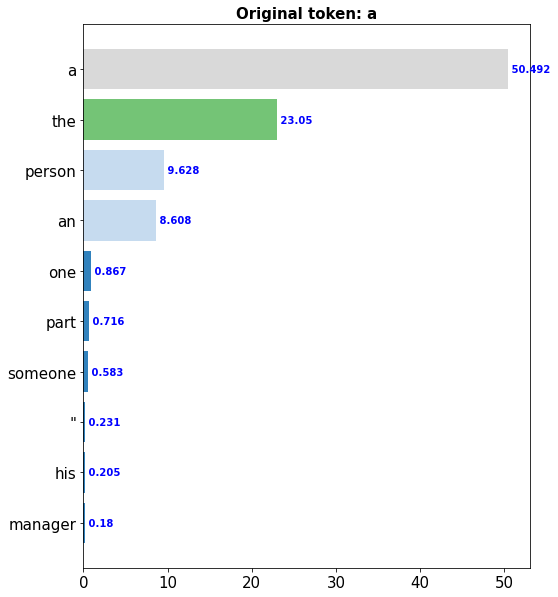

['owner', 'mentor', 'parent', 'coach', 'manager', 'mother', 'dad', 'uncle', 'grandfather', 'father']
[0.002, 0.003, 0.01, 0.01, 0.02, 0.058, 0.064, 0.13, 4.965, 94.711]


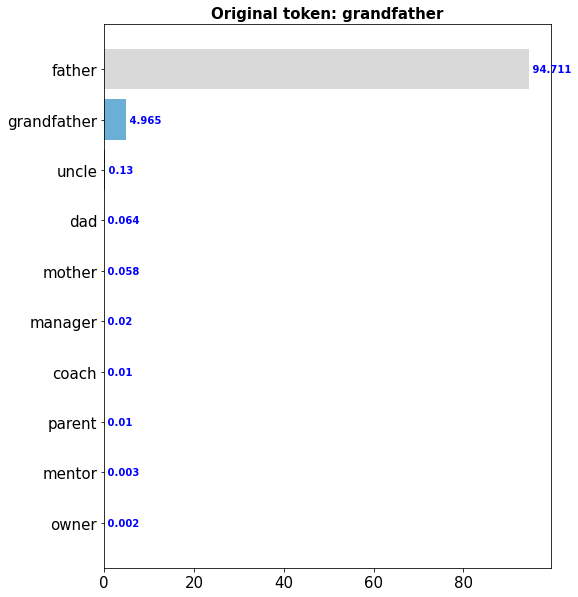

['within', ',', 'with', 'and', 'on', 'for', 'in', 'at', 'to', 'of']
[0.012, 0.016, 0.033, 0.036, 0.042, 0.282, 0.336, 6.234, 31.032, 61.86]


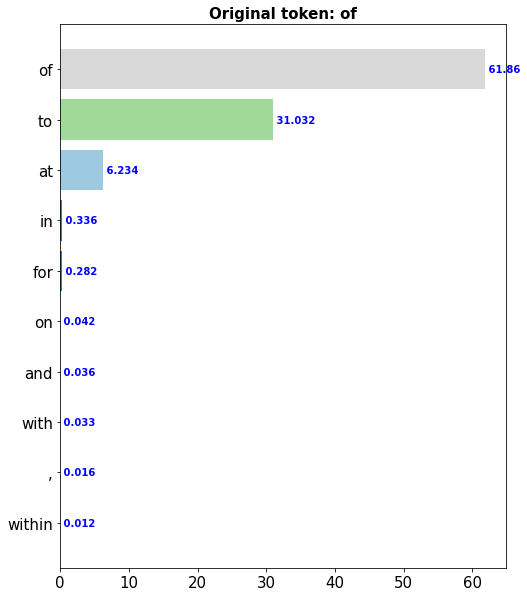

['persons', 'UFC', 'President', 'man', 'all', 'former', '"', 'the', 'Bill', 'person']
[1.214, 1.354, 1.38, 1.384, 1.403, 1.687, 2.872, 2.945, 4.705, 48.331]


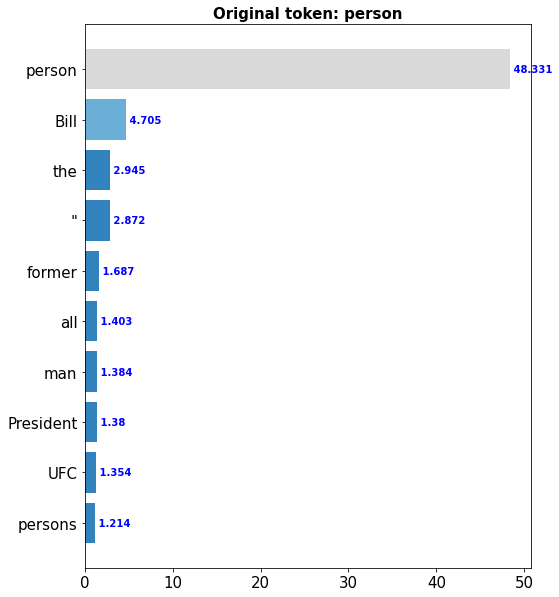

['MS', 'A', 'J', 'M', 'F', 'B', 'E', 'L', 'W', 'H']
[1.306, 1.307, 2.343, 2.701, 4.308, 5.031, 6.833, 7.818, 11.489, 26.182]


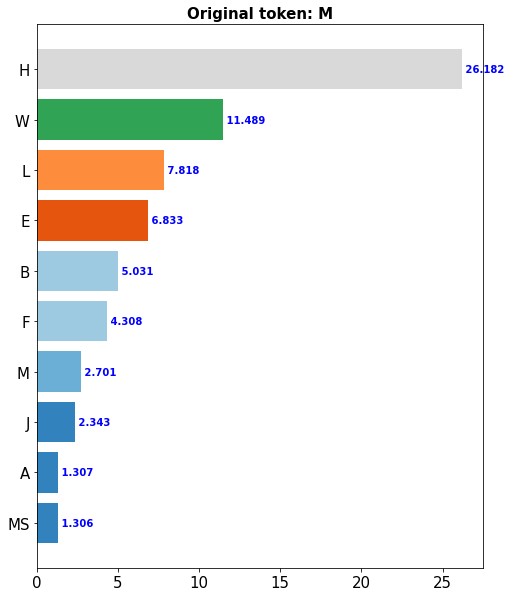

In [6]:


def plot_topk_token(topk_tokens, index):
    plasma = plt.get_cmap('tab20c')
    def rescale(y): return (y - np.min(y)) / (np.max(y) - np.min(y))

    for record in topk_tokens:
        orig = record[0][0]
        tokens = [tok[1] for tok in record]
        probs = [tok[2] for tok in record]

        assert(len(tokens) == len(probs))

        tokens.reverse()
        probs.reverse()

        print(tokens)
        print(probs)

        plt.figure(figsize=(8, 10))
        plt.barh(tokens, probs, color=plasma(rescale(probs)))
        plt.xticks(rotation=0, fontsize=15)
        plt.yticks(rotation=0, fontsize=15)
        plt.title(f"Original token: {orig}", fontsize=15, fontweight='bold')
        for i, v in enumerate(probs):
            plt.text(v, i, " "+str(v), color='blue',
                     va='center', fontweight='bold')
        # plt.savefig(f'./output/token_loss_{index}.png', bbox_inches='tight', dpi=300)
        index += 1
        plt.show()


index = 0
plot_topk_token(topk_tokens_dynamic[0][1], index)


Text(0.5, 0, 'Loss')

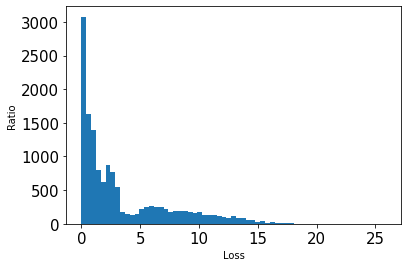

In [31]:
all_loss = []
for inner_loss_token in inner_loss_token_dynamic[:1000]:
    for token_loss in inner_loss_token:
        losses = [loss[0] for loss in list(token_loss.values())[1:]]
        for loss in losses:
            all_loss.append(loss)
all_loss = np.array(all_loss)
q25, q75 = np.percentile(all_loss, [25, 75])
bin_width = 2 * (q75 - q25) * len(all_loss) ** (-1/3)
bins = round((all_loss.max() - all_loss.min()) / bin_width)
plt.figure(figsize=(6, 4))
plt.hist(all_loss, density=False, bins=bins)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Ratio')
plt.xlabel('Loss')

Text(0.5, 0, 'Loss Difference')

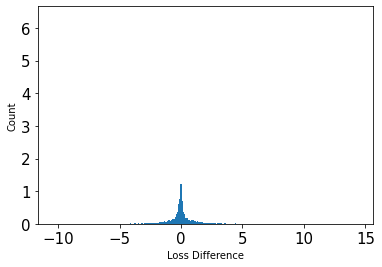

In [32]:
all_loss_diff = []
for inner_loss_token in inner_loss_token_dynamic[:1000]:
    for token_loss in inner_loss_token:
        losses = [loss[1] for loss in list(token_loss.values())[1:]]
        for loss in losses:
            all_loss_diff.append(loss)
all_loss_diff = np.array(all_loss_diff)
q25, q75 = np.percentile(all_loss_diff, [25, 75])
bin_width = 2 * (q75 - q25) * len(all_loss_diff) ** (-1/3)
bins = round((all_loss_diff.max() - all_loss_diff.min()) / bin_width)
plt.figure(figsize=(6, 4))
plt.hist(all_loss_diff, density=True, bins=bins)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Count')
plt.xlabel('Loss Difference')


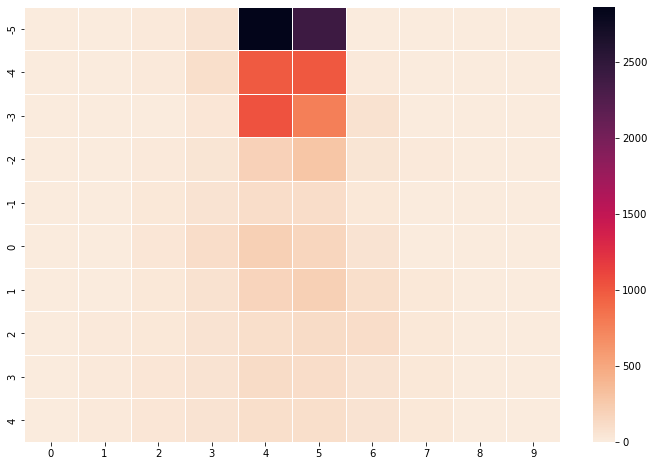

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

hist, xedges, yedges = np.histogram2d(
    all_loss, all_loss_diff, bins=10, range=[[0, 10], [-5, 5]])

xedges = [round(x) for x in xedges]
yedges = [round(y) for y in yedges]

cmap = sns.cm.rocket_r
fig = plt.figure(figsize=(12, 8))
ax = sns.heatmap(
        hist, linewidth=0.8, cmap=cmap,
        xticklabels=xedges[:-1], yticklabels=yedges[:-1])
plt.show()